# Price Prediction

## Data Manipulation

In [3]:
# Data Manipulation
import pandas as pd
import math
from datetime import datetime
import statistics
import numpy as np
# Data Vizualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error

# Arima Model Building
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


# LSTM Model Building
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# Model Building
from sklearn.pipeline import Pipeline

# import keras_tuner



2024-07-26 17:54:07.717255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Get Data

In [5]:
from init_all_data import init_all_required_data

init_all_required_data()


Exception in thread Thread-8:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jaydentani/projects/Stock-Market-Analysis-main/Src/scripts/get_stock_news.py", line 51, in get_and_store_news_api_org_todays_top_business_headlines
    key = read_api_key_from_file(PATH_TO_NEWS_API_ORG_API_KEY)
  File "/Users/jaydentani/projects/Stock-Market-Analysis-main/Src/scripts/get_stock_news.py", line 23, in read_api_key_from_file
    raise Exception("File with api key does not exist")
Exception: File with api key does not exist


Done getting S & P info
Done populating Db with most active stocks
Done getting current most active stocks
Done populating Db with most active stocks


BRK.B: No timezone found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (1d 1925-08-20 -> 2024-07-26)
Exception in thread Thread-7:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jaydentani/projects/Stock-Market-Analysis-main/Src/scripts/get_stock_news.py", line 38, in get_and_store_all_s_and_p_news_from_yfinance_in_DB
    df = df.drop(columns, axis=1)
  File "/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py", line 5258, in drop
    return super().drop(
  File "/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py", line 4549, in drop
    obj = obj._drop_axis(labels, axis, level=level, errors=errors)
  File "/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py", line 4591, in _drop_axis
    new_axis = axis.dr

Done getting all s and p news from yfinance
Done getting top business headlines from newsapi.org


### Map Price to Ticker

In [7]:
import os
from get_stock_data import get_all_price_data_mapped_to_ticker

# os.chdir(os.path.dirname(os.path.abspath(__file__)))
map = get_all_price_data_mapped_to_ticker()

../../data/database/


### Replace index with date

In [9]:
for x in map:
    map[x]['Date'] = pd.to_datetime(map[x]['Date'])
    map[x].set_index("Date", inplace = True)    

<Axes: >

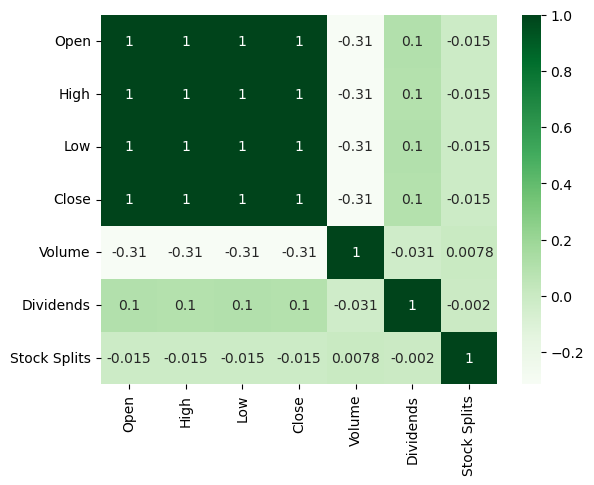

In [10]:

matrix = map["SBUX"].corr()
sns.heatmap(matrix, cmap="Greens", annot=True)

# Arima Model 

### Create Day Difference (Make Stationary)


In [13]:
def create_diff(x):    
    map[x] = map[x][map[x]["Open"] != 0]

    map[x]["day_diff"] = map[x]["Open"].diff(-1)
    map[x].dropna(inplace = True)
    # map[x].index = pd.DatetimeIndex(map[x].index)
    return map[x]

In [14]:
create_diff("AAPL")

,Open,High,Low,Close,Volume,Dividends,Stock Splits,day_diff
Date,,,,,,,,
1980-12-12,0.099058,0.099488,0.099058,0.099058,469033600,0.0,0.0,0.004737
1980-12-15,0.094321,0.094321,0.093890,0.093890,175884800,0.0,0.0,0.006891
1980-12-16,0.087429,0.087429,0.086998,0.086998,105728000,0.0,0.0,-0.001723
1980-12-17,0.089152,0.089582,0.089152,0.089152,86441600,0.0,0.0,-0.002585
1980-12-18,0.091737,0.092167,0.091737,0.091737,73449600,0.0,0.0,-0.005599
...,...,...,...,...,...,...,...,...
2024-07-19,224.820007,226.800003,223.279999,224.309998,49151500,0.0,0.0,-2.189987
2024-07-22,227.009995,227.779999,223.089996,223.960007,48201800,0.0,0.0,2.639999
2024-07-23,224.369995,226.940002,222.679993,225.009995,39960300,0.0,0.0,0.369995


## EDA

In [16]:
# plt.plot((map["AAPL"].loc["6-1-23":"7-31-24"]["day_diff"]))


In [17]:
# map["MMM"]["day_diff"] = [math.log(x)for x in map["MMM"]["day_diff"]]
# plt.plot(math.log(map["MMM"].loc["1-1-22":"12-23-24"]["Open"]))
# plt.plot((map["AAPL"].loc["6-1-23":"7-31-24"]["day_diff"]))

In [18]:
# figure, ax = plt.subplots()

# plot_pacf(map["AAPL"].loc["6-1-23":"7-31-24"]["day_diff"], ax = ax)
# plot_acf(map["AAPL"].loc["6-1-23":"7-31-24"]["day_diff"], ax = ax)

# Model Building

## ARIMA Model(Not useable)

In [21]:
# def create_split(x):
#     global train_set 
#     global test_set
#     train_set = map[x].loc["1-2-24":"5-1-24"]["day_diff"]
#     test_set = map[x].loc["5-1-24":"7-16-24"]["day_diff"]
    


In [22]:
# create_split("MMM")
# train_set

In [23]:
# model = ARIMA(map["MMM"]["day_diff"], order = (4,1,0))
# model_fit = model.fit()
# print(model_fit.summary())


# # forecast_test = model.fit(len())
# output = model_fit.forecast()

In [24]:
# figure, ax = plt.subplots(1) 
# ax.plot(output)
# ax.plot(map["MMM"]["day_diff"])


In [25]:
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()

# LSTM Model

In [639]:
def get_range(df, start, end, days_back):
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)

    df = df.loc[start:end]
    
    # Multivariate
    # df = df[["Close", "Volume"]]

    
    # Univariate
    df = df[["Close"]]

    # Creates new columns
    for x in range(1, days_back + 1):            
        df[f"target - {x}"] = df["Close"].shift(x)
        
    df.dropna(inplace = True)
     
    return df


def seperate_df(df, days_back):
    dates = df.index  
    X = df.iloc[:, 1:]
    X = X.iloc[:, ::-1]
    Y = df[["Close"]]

    return dates, X, Y
    
    

### Set ticker and assign dfs

In [641]:

df = get_range(map["HD"], "1-1-2014", "12-31-2024", 6)


dates, X, y = seperate_df(df, 6)

### Implementing a Scaler

In [643]:
def set_scalers(X, y):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(X)
    X = scaler.transform(X)
    
    y_scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaler.fit(y)
    y = y_scaler.transform(y)
    return X, y
X, y = set_scalers(X, y)

### Create train, validation, and test split

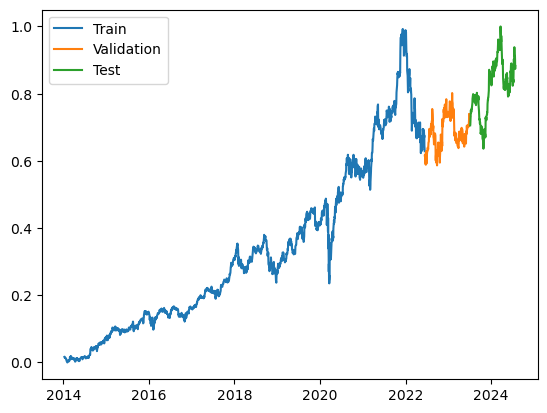

In [645]:

def create_split(X, y, dates):
    global q_80, q_90, dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test
    
    q_80 = int(len(dates) * .8)
    q_90 = int(len(dates) * .9)
    
    dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
    
    dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
    dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

create_split(X, y, dates)

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

## Model Construction

In [36]:
# def build_model(hp):
#   model = keras.Sequential()
#   model.add(keras.layers.Dense(
#       hp.Choice('units', [8, 16, 32]),
#       activation='relu'))
#   model.add(keras.layers.Dense(1, activation='relu'))
#   model.compile(loss='mse')
#   return model
# tuner = keras_tuner.RandomSearch(
# build_model,
# objective='val_loss',
# max_trials=5)
# tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
# best_model = tuner.get_best_models()[0]


In [647]:
# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
# model.add(LSTM(64, return_sequences=False))
# model.add(Dense(25, activation = 'relu'))
# model.add(Dense(1))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# # Train the model
# model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=5, epochs=200)


model = Sequential([layers.LSTM(256, return_sequences = True, input_shape=(X_train.shape[1],1)),
            layers.Dropout(.3),
            layers.LSTM(128),
            layers.Dense(64),
            layers.Dense(32),
            layers.Dense(1)])
# model = Sequential([layers.LSTM(128, return_sequences = True, input_shape=(X_train.shape[1],1)),
#                     # layers.Dropout(.3),
#                     layers.LSTM(128, return_sequences = True),
#                     # layers.Dropout(.2),
#                     layers.LSTM(64, return_sequences = True),
#                     layers.Dense(128)
#                     layers.Dense(64),
#                     layers.Dense(64),
#                     layers.Dense(32),
#                     layers.Dense(32),
#                     layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=75)

Epoch 1/75
67/67 [==============================] - 3s 20ms/step - loss: 0.0114 - mean_absolute_error: 0.0488 - val_loss: 4.9765e-04 - val_mean_absolute_error: 0.0171
Epoch 2/75
67/67 [==============================] - 1s 13ms/step - loss: 3.5776e-04 - mean_absolute_error: 0.0136 - val_loss: 4.8866e-04 - val_mean_absolute_error: 0.0170
Epoch 3/75
67/67 [==============================] - 1s 14ms/step - loss: 3.3631e-04 - mean_absolute_error: 0.0129 - val_loss: 5.8272e-04 - val_mean_absolute_error: 0.0188
Epoch 4/75
67/67 [==============================] - 1s 13ms/step - loss: 2.8633e-04 - mean_absolute_error: 0.0119 - val_loss: 5.7412e-04 - val_mean_absolute_error: 0.0186
Epoch 5/75
67/67 [==============================] - 1s 13ms/step - loss: 3.2435e-04 - mean_absolute_error: 0.0131 - val_loss: 4.5094e-04 - val_mean_absolute_error: 0.0164
Epoch 6/75
67/67 [==============================] - 1s 13ms/step - loss: 3.0646e-04 - mean_absolute_error: 0.0123 - val_loss: 4.5412e-04 - val_mean_a

## Combined plots

67/67 [==============================] - 0s 4ms/step


1.649086350041565

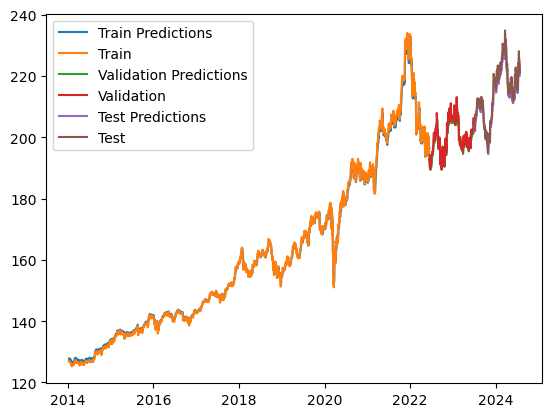

In [649]:
test_predictions = model.predict(X_test)
val_predictions = model.predict(X_val)
train_predictions = model.predict(X_train)

plt.plot(dates_train, y_scaler.inverse_transform(train_predictions))
plt.plot(dates_train, y_scaler.inverse_transform(y_train))
plt.plot(dates_val, y_scaler.inverse_transform(val_predictions))
plt.plot(dates_val, y_scaler.inverse_transform(y_val))
plt.plot(dates_test, y_scaler.inverse_transform(test_predictions))
plt.plot(dates_test, y_scaler.inverse_transform(y_test))
plt.legend(['Train Predictions', 'Train ', 'Validation Predictions', 'Validation', 'Test Predictions', 'Test'])
mean_absolute_error(y_scaler.inverse_transform(test_predictions), y_scaler.inverse_transform(y_test))

In [659]:
prediction_results = []

def simulate_model(repeats, days_back, ticker, epochs):
    for x in range(repeats):
        # map = get_all_price_data_mapped_to_ticker()
        # for x in map:
            # map[x]['Date'] = pd.to_datetime(map[x]['Date'])
            # map[x].set_index("Date", inplace = True)    
    
    
        
        # Assign train ticker and start and end dates
        df = get_range(map[ticker], "1-1-2023", "12-31-2024", days_back)
        
        dates, X, y = seperate_df(df, days_back)
        
        # Implement Scaler
        X, y = set_scalers(X, y)
        
        # Create train, val, and test split
        create_split(X, y, dates)
    
    
    
        # Create/Train model

        # Model 8, 75, 14-15 ms
        # model = Sequential([layers.LSTM(256, return_sequences = True, input_shape=(X_train.shape[1],1)),
        #             layers.Dropout(.3),
        #             layers.LSTM(128),
        #             layers.Dense(64),
        #             layers.Dense(32),
        #             layers.Dense(32),
        #             layers.Dense(32),
        #             layers.Dense(1)])

        # Model 10, 75, 14-15ms
        model = Sequential([layers.LSTM(256, return_sequences = True, input_shape=(X_train.shape[1],1)),
                    layers.Dropout(.3),
                    layers.LSTM(128),
                    layers.Dense(128),
                    layers.Dense(64),
                    layers.Dense(32),
                    layers.Dense(32),
                    layers.Dense(16),
                    layers.Dense(1)])

        # Model 11, 75
        # model = Sequential([layers.LSTM(256, return_sequences = True, input_shape=(X_train.shape[1],1)),
        #             layers.Dropout(.3),
        #             layers.LSTM(128),
        #             layers.Dense(64),
        #             layers.Dense(32),
        #             layers.Dense(1)])

        
        model.compile(loss='mse', 
                      optimizer=Adam(learning_rate=0.001),
                      metrics=['mean_absolute_error'])
        
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)
        # Get/Plot predictions
        test_predictions = model.predict(X_test)
        # val_predictions = model.predict(X_val)
        # train_predictions = model.predict(X_train)
        
        # fig, ax = plt.subplots(figsize = (10,5))
        # plt.plot(dates_train, train_predictions)
        # plt.plot(dates_train, y_train)
        # plt.plot(dates_val, val_predictions)
        # plt.plot(dates_val, y_val)
        # plt.plot(dates_test, test_predictions)
        # plt.plot(dates_test, y_test)
        prediction_results.append(mean_absolute_error(y_scaler.inverse_transform(test_predictions), y_scaler.inverse_transform(y_test)))



simulate_model(20, 5, "AAPL", 75)

Epoch 1/75
10/10 [==============================] - 3s 68ms/step - loss: 0.1055 - mean_absolute_error: 0.2553 - val_loss: 0.0271 - val_mean_absolute_error: 0.1573
Epoch 2/75
10/10 [==============================] - 0s 16ms/step - loss: 0.0163 - mean_absolute_error: 0.1056 - val_loss: 0.0247 - val_mean_absolute_error: 0.1228
Epoch 3/75
10/10 [==============================] - 0s 15ms/step - loss: 0.0067 - mean_absolute_error: 0.0666 - val_loss: 0.0213 - val_mean_absolute_error: 0.1130
Epoch 4/75
10/10 [==============================] - 0s 14ms/step - loss: 0.0048 - mean_absolute_error: 0.0547 - val_loss: 0.0260 - val_mean_absolute_error: 0.1327
Epoch 5/75
10/10 [==============================] - 0s 14ms/step - loss: 0.0034 - mean_absolute_error: 0.0453 - val_loss: 0.0136 - val_mean_absolute_error: 0.0760
Epoch 6/75
10/10 [==============================] - 0s 14ms/step - loss: 0.0031 - mean_absolute_error: 0.0427 - val_loss: 0.0114 - val_mean_absolute_error: 0.0648
Epoch 7/75
10/10 [====

In [661]:
# df_predictions = pd.DataFrame()
# df_predictions
prediction_results

# df_predictions.drop(["model 9", "model 12"], axis = 1, inplace = True)

[3.1516980736427014,
 3.275120805736087,
 2.9327292676204317,
 3.6969032748742077,
 2.9305066032701417,
 2.9337995927642706,
 3.3135015508657943,
 3.4405552273732063,
 3.365653548663182,
 4.057403424760021,
 3.2395375393498194,
 2.912937085792177,
 3.203779646346528,
 2.949738540117539,
 4.569520061419477,
 5.872186910326864,
 2.9226638575003503,
 3.7768538520476853,
 3.3429658207881343,
 3.094191947396796]

In [617]:

df_predictions.insert(3, "model 11*", prediction_results)

In [50]:
temp =  df["Close"][-6:].to_numpy()

predicted_values = []
pred_dates = pd.date_range(start = df.index[-1] + pd.Timedelta(days=1), periods = 6)
for x in range(6):

    scaled_temp = scaler.transform(temp.reshape(1, 6))
    temp = np.append(temp, model.predict(scaled_temp))
    predicted_values.append(model.predict(scaled_temp).reshape(1))
    temp = np.delete(temp, 0)

predicted_df = pd.DataFrame(predicted_values, index = pred_dates)


1/1 [==============================] - 0s 16ms/step


/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 15ms/step


/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 15ms/step


In [54]:
predicted_df

,0
2024-07-26,75.096466
2024-07-27,75.237038
2024-07-28,75.130569
2024-07-29,75.132431
2024-07-30,75.112732
2024-07-31,75.146843


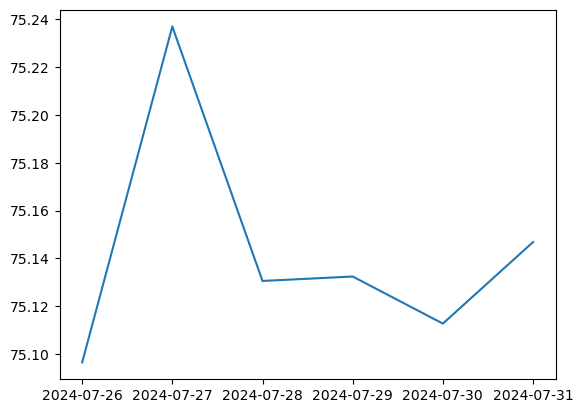

In [56]:
plt.plot(predicted_df)